In [1]:
import pyproj
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt

In [2]:
filepath = "MG_setores_CD2022/MG_setores_CD2022.shp"
gdf = gpd.read_file(filepath)

C:\Users\renan\anaconda3\Lib\site-packages\pyogrio\core.py:36: RuntimeWarning: Could not detect PROJ data files. Set PROJ_LIB environment variable to the correct path.
  _init_proj_data()


In [3]:
gdf_cidade = gdf[gdf['CD_MUN'] == '3106200']

In [4]:
# Define the list of column names you want to read
desired_columns = [
    'CD_SETOR', 
    'V01317', 
    'V01318', 
    'V01319', 
    'V01320', 
    'V01321'
]

# Read the CSV file, loading only the specified columns
df = pd.read_csv('Agregados_por_setores_cor_ou_raca_BR_csv/Agregados_por_setores_cor_ou_raca_BR.csv', sep = ';', usecols=desired_columns)

# Display the resulting DataFrame to verify
print(df.head())

          CD_SETOR V01317 V01318 V01319 V01320 V01321
0  110001505000002    312     87      X    514     13
1  110001505000003    189     25      0    336      6
2  110001505000004     71     14      0    135      X
3  110001505000006    255     54      X    460     14
4  110001505000007    229     49      X    459     10


C:\Users\renan\AppData\Local\Temp\ipykernel_42088\3889989446.py:12: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Agregados_por_setores_cor_ou_raca_BR_csv/Agregados_por_setores_cor_ou_raca_BR.csv', sep = ';', usecols=desired_columns)


In [5]:
df['CD_SETOR'] = df['CD_SETOR'].astype('str')

In [6]:
merged_gdf = gdf_cidade.merge(
    df,
    on='CD_SETOR',  # Join on CD_SETOR column
    how='left'      # Use left join to keep all records from gdf_poa
)

In [7]:
cols_to_clean = ['V01317', 'V01318', 'V01319', 'V01320', 'V01321']
merged_gdf[cols_to_clean] = merged_gdf[cols_to_clean].replace('X', 0)
merged_gdf = merged_gdf.fillna(0)

C:\Users\renan\AppData\Local\Temp\ipykernel_42088\4202078396.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_gdf = merged_gdf.fillna(0)


In [8]:
merged_gdf[cols_to_clean] = merged_gdf[cols_to_clean].astype('int64')

In [9]:
merged_gdf['pop_total'] = merged_gdf[cols_to_clean].sum(axis=1)
# Percentual de pretos e pardos
merged_gdf['pp_total'] = merged_gdf['V01318'] + merged_gdf['V01320']
merged_gdf['ppp'] = merged_gdf['pp_total'] / merged_gdf['pop_total']

## Mapa Estático

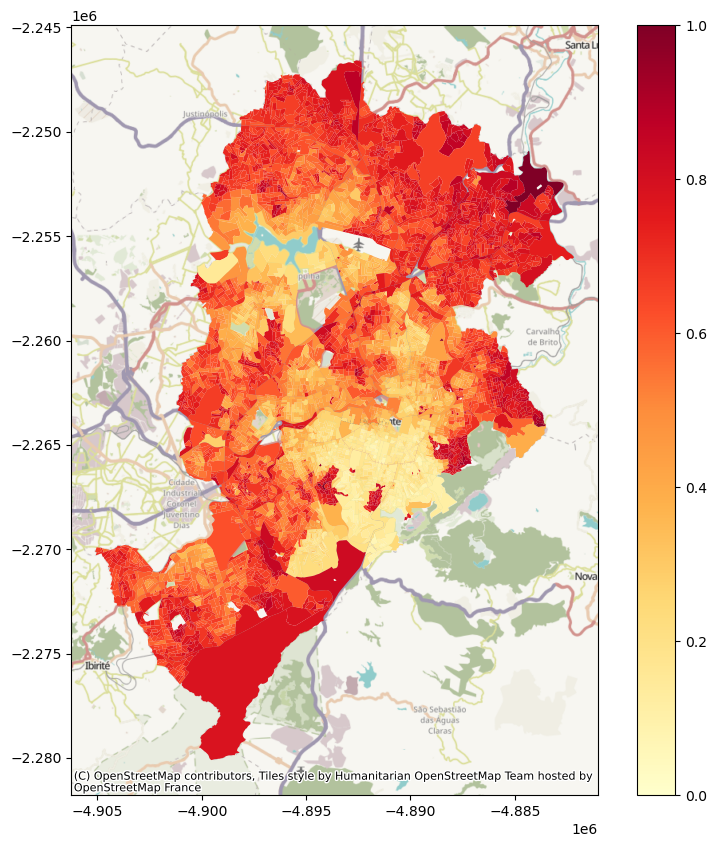

In [10]:
# Create the plot and get the axes object
ax = merged_gdf.to_crs(epsg=3857).plot(
    column='ppp',      # The name of the numeric column to use for coloring
    cmap='YlOrRd',        # The colormap to use (viridis is a good default or YlOrRd)
    legend=True,           # Display the color bar legend
    figsize=(10, 10)        # Optional: control the figure size
)

# Add the basemap
cx.add_basemap(ax)

# Optional: Customize or remove the axis for a cleaner map
# ax.set_axis_off()

plt.show()

## Mapa Dinâmico

In [19]:
merged_gdf[['geometry', 'NM_BAIRRO', 'ppp']].to_crs(epsg=3857).explore(
    column="ppp", # Column to use for coloring the map
    tooltip=False,         # Show all data columns on hover
    popup=True,           # Show all data columns on click
    cmap="YlOrRd",       # Color map
    tiles="OpenStreetMap" # Base map tiles
)

## Cálculo de Medidas de Segregação

In [20]:
from segregation.singlegroup import Dissim, Isolation, RelativeConcentration, RelativeCentralization, RelativeClustering, SpatialDissim
from segregation import inference

In [13]:
merged_gdf = merged_gdf.to_crs(epsg=3857)

In [14]:
dissim = Dissim(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')
isol = Isolation(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')
conc = RelativeConcentration(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')
cent = RelativeCentralization(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')
clust = RelativeClustering(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')

In [15]:
print(dissim.statistic)
print(isol.statistic)
print(conc.statistic)
print(cent.statistic)
print(clust.statistic)

0.35021414807515844
0.6371511245689692
-0.10820249686750398
-0.23376004234933134
0.05068193006799282


In [16]:
rside_test = inference.SingleValueTest(dissim, null_approach='evenness')

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
rside_test.p_value

np.float64(0.0)

<Axes: title={'center': 'Dissim (Value = 0.35)'}, ylabel='Count'>

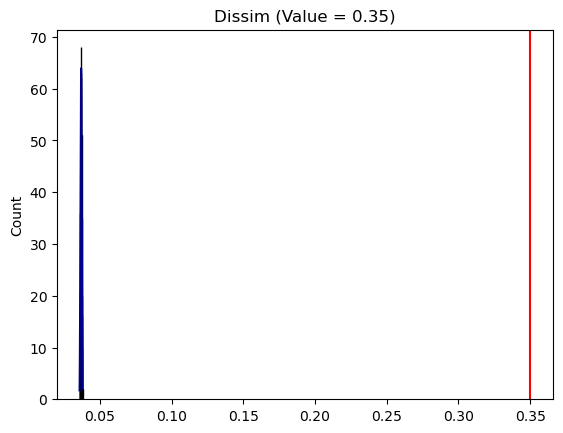

In [18]:
rside_test.plot()

In [21]:
s_dissim = SpatialDissim(merged_gdf, group_pop_var='pp_total', total_pop_var='pop_total')

C:\Users\renan\anaconda3\Lib\site-packages\segregation\singlegroup\spatial_dissim.py:48: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_object = Queen.from_dataframe(data)


In [22]:
s_dissim.statistic

np.float64(0.2586190128446201)